# Transformer recipe generator analysis

Note: This notebook is designed to run with CPU (no GPU) runtime.

Install Huggingface libraries to use the pretrained tokenizer.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.4 MB/s eta 0:00:00


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai 1.61.1 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
langsmith 0.3.11 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.


Import modules and set random seeds.

In [3]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, saving
from googletrans import Translator

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [5]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 30522


Dfiner the Transformer encoder block.

In [ ]:
@saving.register_keras_serializable()
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
        super(Embeddings, self).__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(max_len, embed_dim)
        self.ln = layers.LayerNormalization(epsilon=1e-12)
        self.dropout = layers.Dropout(rate=0.5)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)
        token_embeddings = self.token_emb(inputs)

        # Add positional embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def build(self, input_shape):
        pass

    def get_config(self):
        config = super().get_config()
        config.update({
            'max_len': self.max_len,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config

Define the Transformer model consisted of a single Transformer encoder blocks.

In [ ]:
@saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim)
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Multi-head attention
        attention_output, attention_scores = self.attn(
            inputs, inputs, inputs, # Inputs for Query, Value, Key
            use_causal_mask=True,
            return_attention_scores=True)
        attention_output = self.dropout_1(attention_output)
        attention_output = attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        # Feed forward
        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def build(self, input_shape):
        pass

    def get_config(self):
        config = super().get_config()
        config.update({
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
        })
        return config

Mount google drive and load the trained model.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_file = '/content/gdrive/My Drive/Transformer_attention_scores.keras'
attention_scores_model = saving.load_model(model_file)
attention_scores_model.summary()

Mounted at /content/gdrive


Model: "Transformer_attention_scores"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_embedding (Embeddings)     │ (None, None, 512)      │    15,693,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer (TransformerBlock)  │ [(None, None, 512),    │     3,152,384 │
│                                 │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, None, 30522)    │    15,657,786 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,503,994 (131.62 MB)

 Trainable params: 34,503,994 (131.62 MB)

 Non-trainable params: 0 (0.00 B)

Define a function to generate new texts.

In [ ]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    answer = prompt
    print(answer, end='')

    c = 1
    for i in range(512):
        probs, _ = attention_scores_model.predict(np.array([input_ids]), verbose=0)
        next_token, _ = sample_from(probs[0][-1], temp)
        input_ids = np.append(input_ids, next_token)

        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        if next_word.startswith('##'):
            next_word = next_word[2:]
        elif next_word not in ['.', ',', ':', ';', '?', '!']:
            next_word = ' ' + next_word
        print(next_word, end='')
        answer += next_word
        if len(answer) > c * 100:
            c += 1
            print('')
    print('')

    if lang == 'en':
        return answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return translated.text

Generate some sample texts.

**一例として、「Recipe for black」で始まるテキストを温度パラメーター 1.0 で 2 回生成します。**

温度パラメーターが大きい場合、実行ごとに生成されるテキストの内容が大きく変わります。

In [ ]:
gen_text('Recipe for black', temp=1.0, lang='ja')

Recipe for black bean and potato stew: cook and stir the ground beef in a large pot over medium - high
 heat until browned, about 10 minutes. add onions and beef; cook for 5 minutes more. add broth and dried
 tomatoes; cook until potatoes are tender, about 20 minutes. mix shrimp soup, and heavy cream mixture
 into turkey mixture, stir into vegetables; stir to combine. cook and stir for 1 minute more. pour
 into tomato paste mixture; bring to a boil; reduce heat and simmer until wine is reduced by half
, and carefully pour water into the stock and bring to a boil. cook for 5


'黒豆とジャガイモのシチューのレシピ：牛ひき肉を中程度の鍋で調理して、茶色になるまで、約10分間強火をかけます。玉ねぎと牛肉を追加します。さらに5分間調理します。スープとドライトマトを加えます。ジャガイモが柔らかくなるまで、約20分調理します。エビのスープとヘビークリームの混合物を七面鳥の混合物に混ぜ、野菜にかき混ぜます。混ぜ合わせます。さらに1分間かき混ぜます。トマトペーストの混合物に注ぎます。沸騰させます。熱を減らし、ワインが半分になるまで煮込み、在庫に水を慎重に注ぎ、沸騰させます。5で調理します'

In [ ]:
gen_text('Recipe for black', temp=1.0, lang='ja')

Recipe for black bean and spinach quiche: bring broth to a boil in a boil over high heat until quinoa
 is tender and broth is absorbed and chicken is just tender and the liquid is absorbed, 35 to 40 minutes
. pour the chicken broth into a large bowl, mashed potatoes and cook for 1 minute. transfer to a
 blender stir in minced onion, avocado, chickpeas, and salt into turkey mixture; bring to a boil; cook
 until the pasta is cooked through and bubbly, about 45 minutes. season with garlic powder.


'黒豆とほうれん草のキッシュのレシピ：キノアが柔らかく、スープが吸収され、鶏肉が柔らかくなり、液体が吸収されるまで、強火で沸騰してスープを沸騰させて35〜40分。チキンスープを大きなボウルに注ぎ、ジャガイモをマッシュし、1分間調理します。刻んだタマネギ、アボカド、ひよこ豆、塩でブレンダーに移動して七面鳥の混合物に移します。沸騰させます。パスタが透けて調理され、約45分間調理されるまで調理します。ニンニク粉で味付けします。'

**次は、「Recipe for black」で始まるテキストを温度パラメーター 0.1 で 2 回生成します。**

温度パラメーターが大きい場合、実行ごとに類似した内容のテキストが生成されます。

また、1 つのテキストの中で同じ文章が繰り返されることがあります。

In [ ]:
gen_text('Recipe for black', temp=0.1, lang='ja')

Recipe for black bean and black bean soup: heat the olive oil in a large pot over medium heat. add the
 onion, and cook until translucent, about 5 minutes. add the beans, and cook until the onion is translucent
, about 5 minutes. stir in the black beans, black beans, black beans, and black beans; bring
 to a boil, reduce heat to low, and simmer until the beans are tender, about 10 minutes. season with
 salt and pepper.


'黒豆と黒豆のスープのレシピ：中火でオリーブオイルを大きな鍋で加熱します。タマネギを加え、半透明になるまで約5分間調理します。豆を加え、タマネギが半透明になるまで約5分間調理します。黒豆、黒豆、黒豆、黒豆をかき混ぜます。沸騰させ、熱を低くし、豆が柔らかくなるまで約10分間煮ます。塩とコショウで味付けします。'

In [ ]:
gen_text('Recipe for black', temp=0.1, lang='ja')

Recipe for black bean and black bean soup: heat the olive oil in a large pot over medium heat. add the
 onion, and cook until translucent, about 5 minutes. add the beans, and cook until the onion is translucent
, about 5 minutes. stir in the black beans, black beans, black beans, and black beans; bring
 to a boil, then reduce heat to low, and simmer for about 20 minutes. stir in the black beans, and black
 beans; cook until the beans are tender, about 10 minutes.


'黒豆と黒豆のスープのレシピ：中火でオリーブオイルを大きな鍋で加熱します。タマネギを加え、半透明になるまで約5分間調理します。豆を加え、タマネギが半透明になるまで約5分間調理します。黒豆、黒豆、黒豆、黒豆をかき混ぜます。沸騰させてから、熱を低くし、約20分間煮ます。黒豆と黒豆をかき混ぜます。豆が柔らかくなるまで約10分間調理します。'

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

**一例として、上記で生成されたテキストの先頭部分（を少し短くしたもの）を用いて、ウェイトの値を表示します。**

テキストの生成が進むにつれて、次の単語を予測するために注目する場所が変化する様子がわかります。

In [ ]:
prompts = [
    'Recipe for potato stew: cook and stir the ground beef in a large pot'
]

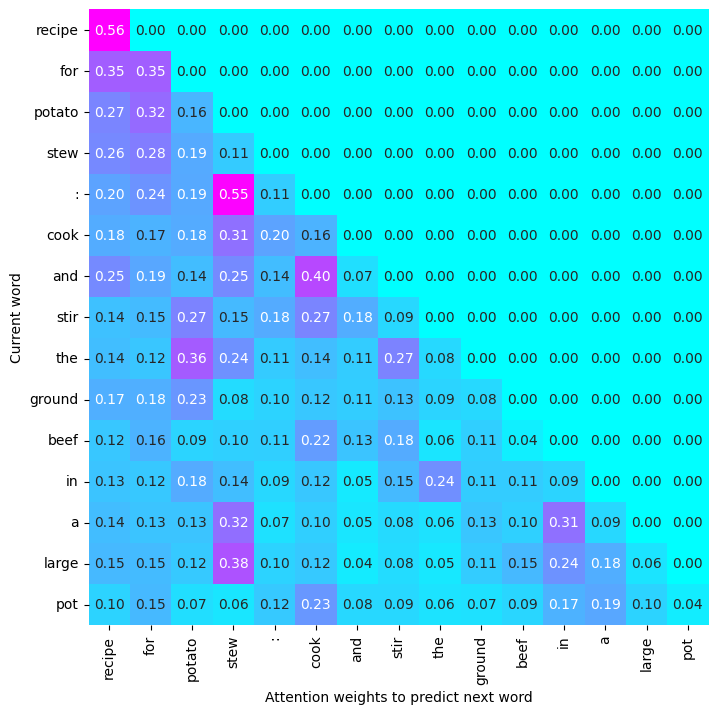

In [ ]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(
                                np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(
        np.max(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
        ax = subplot,
        cmap='cool', cbar=False, annot=True, fmt='1.2f')
    heatmap.set_xticklabels(labels[1:text_len], rotation = 90)
    heatmap.set_yticklabels(labels[1:text_len], rotation = 0)
    _ = heatmap.set(xlabel='Attention weights to predict next word',
                    ylabel='Current word')